In [163]:
pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [164]:
import tensorflow as tf
import os

In [165]:
# Limit tensorflow usage of system VRAM, only using what's needed
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [166]:
import cv2, imghdr, numpy as np
from matplotlib import pyplot as plt

In [167]:
# Delete files that are less than 10KB (img too small)
directory = '/Users/uddam/desktop/projects/Binary_Classifier/data'
subdirectories = ['men', 'women']

total_deleted = 0
total_remaining = 0

for subdir in subdirectories:
    subdir_path = os.path.join(directory, subdir)
    for entry in os.scandir(subdir_path):
        if entry.is_file() and entry.stat().st_size < 10240:
            os.remove(entry.path)
            total_deleted += 1
        else:
            total_remaining += 1

print(f"Total files deleted: {total_deleted}")
print(f"Total files remaining: {total_remaining}")

Total files deleted: 0
Total files remaining: 57


In [168]:
# Delete files with funny extensions and wronge sRGB colors

from PIL import Image

data_dir = 'data'
img_ext = ['jpg', 'jpeg', 'png']

for subdir in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, subdir)
    
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, file)

            try:
                img = Image.open(img_path)
                ext = imghdr.what(img_path)
                
                if ext not in img_ext or img.info.get('icc_profile') is None:
                    os.remove(img_path)
                else:
                    img.convert("RGB").save(img_path, icc_profile=img.info.get('icc_profile'))
            except Exception as e:
                os.remove(img_path)


In [169]:
# Use keras to store imgs to a dataset
# run 'tf.keras.utils.image_dataset_from_directory??' to understand what it doess
data = tf.keras.utils.image_dataset_from_directory('data')

Found 57 files belonging to 2 classes.


In [170]:
# This is so we can get a batch back from the dataset
data_itr = data.as_numpy_iterator()
batch = data_itr.next()

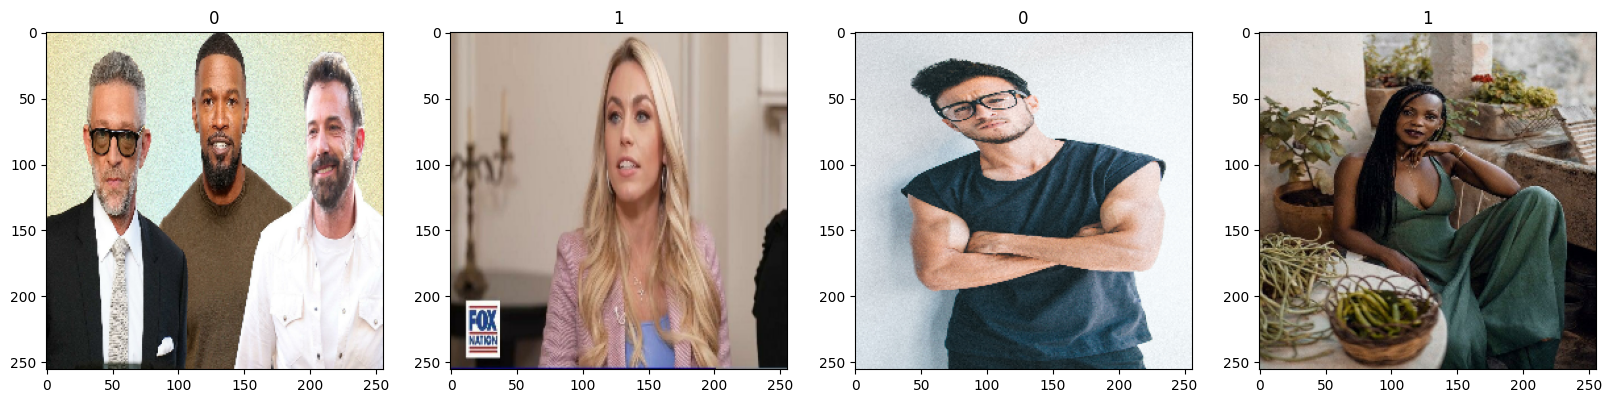

In [171]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(str(batch[1][idx]))

# Seems like men are 0, women are 1


In [172]:
# Scaling data down to save on optimization
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()[0]

array([[[[0.94620097, 0.94620097, 0.94620097],
         [0.94620097, 0.94620097, 0.94620097],
         [0.94620097, 0.94620097, 0.94620097],
         ...,
         [0.94620097, 0.94620097, 0.94620097],
         [0.94620097, 0.94620097, 0.94620097],
         [0.94620097, 0.94620097, 0.94620097]],

        [[0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         ...,
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ]],

        [[0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         ...,
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ]],

        ...,

        [[0.94509804, 0.94509804, 0.94509804],
         [0.94509804, 0.94509804, 0.94509804]

In [182]:
# Spliting dataset
train_size = int(len(data)*0.7)
valid_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [184]:
train = data.take(train_size)
val = data.skip(train_size).take(valid_size)
test = data.skip(train_size+valid_size).take(test_size)

In [192]:
# Build Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [193]:
model = Sequential()

In [194]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [195]:
# Use adam optimizer
# tf.optimizers. to view more
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [196]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

In [197]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.6868 - accuracy: 0.5938
Epoch 2/20
1/1 [==============================] - 1s 961ms/step - loss: 0.5734 - accuracy: 0.6875
Epoch 3/20
1/1 [==============================] - 1s 973ms/step - loss: 3.2245 - accuracy: 0.4375
Epoch 4/20
1/1 [==============================] - 1s 961ms/step - loss: 0.7841 - accuracy: 0.5938
Epoch 5/20
1/1 [==============================] - 1s 958ms/step - loss: 0.9745 - accuracy: 0.4375
Epoch 6/20
1/1 [==============================] - 1s 946ms/step - loss: 0.4750 - accuracy: 0.8750
Epoch 7/20
1/1 [==============================] - 1s 946ms/step - loss: 0.6394 - accuracy: 0.5625
Epoch 8/20
1/1 [==============================] - 1s 950ms/step - loss: 0.7589 - accuracy: 0.5000
Epoch 9/20
1/1 [==============================] - 1s 977ms/step - loss: 0.5036 - accuracy: 0.7188
Epoch 10/20
1/1 [==============================] - 1s 955ms/step - loss: 0.5061 - accuracy: 0.6562
Epoch 11/20
1/1 [=====

In [204]:
hist.history.keys()

dict_keys(['loss', 'accuracy'])

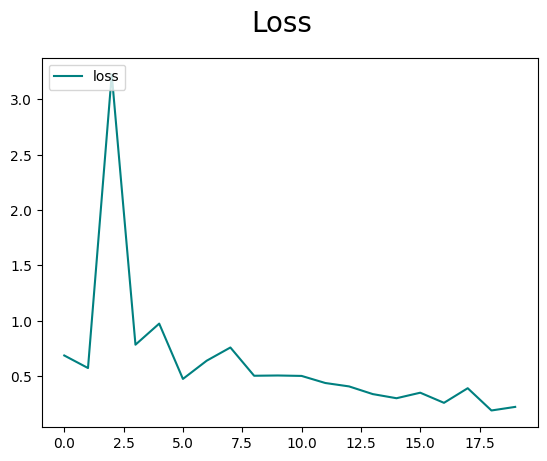

In [205]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

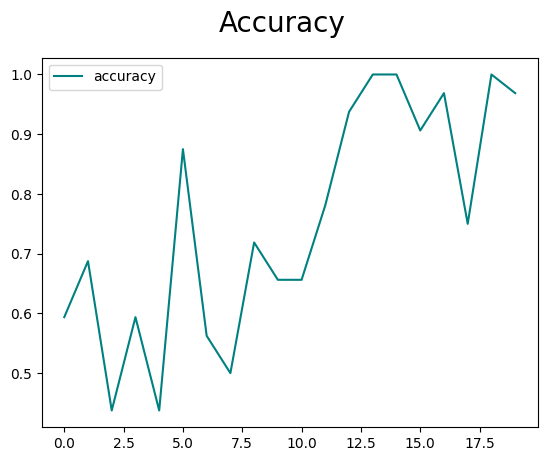

In [206]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [207]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [208]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [209]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 97ms/step


In [210]:
print(pre.result(), re.result(), acc.result())


tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9230769, shape=(), dtype=float32) tf.Tensor(0.96, shape=(), dtype=float32)


In [211]:
import cv2


In [225]:
img = cv2.imread('slider-women-final-1.png')

[ WARN:0@6484.296] global loadsave.cpp:244 findDecoder imread_('slider-women-final-1.png'): can't open/read file: check file path/integrity


In [233]:
# resize = tf.image.resize(img, (256,256))

In [234]:
yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [ ]:
# save the model 